# Data description & Problem statement: 
Retail is another industry which extensively uses analytics to optimize business processes. Tasks like product placement, inventory management, customized offers, product bundling, etc. are being smartly handled using data science techniques. As the name suggests, this data comprises of transaction records of a sales store. This is a Regression problem. The data has 8523 rows of 12 variables.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc.
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Build an initial XGBoost model, and evaluate it via C-V approach
- Use grid-search along with C-V approach to find the best hyperparameters of XGBoost model: Find the best XGBoost model 
   # Model Evaluation: 
- Evaluate the best XGBoost model with optimized hyperparameters on Test Dataset, by calculating:
     - r2 (determination factor)
     - Lift chart
     - RMSE 
     - Box-plot for prediction Vs. actual values 
     - Distribution plot of error/residuals
     
Finally, calculate the Feature Importance. 

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/Big mart sales/Train.csv')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


In [3]:
df.drop(['Item_Identifier', 'Outlet_Identifier', 'Item_Weight' ], axis=1, inplace=True)

df['Item_Fat_Content']=df['Item_Fat_Content'].map({'Low Fat':'L', 'low fat':'L', 'LF':'L', 'Regular':'R', 'reg':'R'})

df.loc[df['Outlet_Establishment_Year']== 1998]= df.loc[df['Outlet_Establishment_Year'] == 1998].fillna('small')

df.dropna(axis=0, inplace=True)

df.shape

(6668, 9)

In [4]:
L_con=['Item_Visibility', 'Item_MRP' ]
L_cat=['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
L_nom=['Item_Fat_Content', 'Item_Type', 'Outlet_Establishment_Year']

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

for i in L_cat:
    encode_text_index(df, i)
    
for i in L_nom:
    encode_text_index(df, i)
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
for name in ['Item_Type']:
    encode_text_dummy(df, name)

In [5]:
X=df.drop(['Item_Outlet_Sales'], axis=1)
y=np.sqrt(df['Item_Outlet_Sales'])

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

scalor_X=MinMaxScaler().fit(pd.DataFrame(X_train))
X_train=scalor_X.transform(pd.DataFrame(X_train))
X_test=scalor_X.transform(pd.DataFrame(X_test))

scaler_y=MinMaxScaler().fit(pd.DataFrame(y_train))
y_train=scaler_y.transform(pd.DataFrame(y_train))
y_test=scaler_y.transform(pd.DataFrame(y_test))

In [6]:
# Building the Initial Model & Cross-Validation: 
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold

model=XGBRegressor() 
kfold=KFold(n_splits=5, shuffle=True, random_state=42)
scores=cross_val_score(model, X_train, y_train, cv=kfold)

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.71937044 0.7000113  0.67637896 0.7027266  0.71874308] 

Accuracy: 0.70 (+/- 0.02)


In [7]:
# Grid-Search for the best model parameters: 

from sklearn.model_selection import GridSearchCV
param={'max_depth':[2, 4, 6], 'min_child_weight':[1, 2], 'gamma': [ 0, 0.05, 1], 'subsample':[0.7, 1]}

kfold=KFold(n_splits=3, shuffle=True, random_state=42)
grid_search=GridSearchCV(XGBRegressor(seed=42), param, cv=kfold, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
G.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
15,0.302192,0.034616,0.015625,0.014480,0.05,2,2,1,"{'gamma': 0.05, 'max_depth': 2, 'min_child_wei...",0.708629,0.691378,0.716347,0.705451,0.010438,1,0.714665,0.725802,0.711610,0.717359,0.006099
13,0.421537,0.020348,0.006647,0.004485,0.05,2,1,1,"{'gamma': 0.05, 'max_depth': 2, 'min_child_wei...",0.708629,0.691378,0.716347,0.705451,0.010438,1,0.714665,0.725802,0.711610,0.717359,0.006099
12,0.380980,0.032806,0.012636,0.012940,0.05,2,1,0.7,"{'gamma': 0.05, 'max_depth': 2, 'min_child_wei...",0.710210,0.689386,0.716659,0.705418,0.011638,3,0.721084,0.729590,0.716479,0.722384,0.005431


In [8]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'gamma': 0.05, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 1}
Best validation accuracy:  0.71 (+/- 0.01)
Test score:  0.7


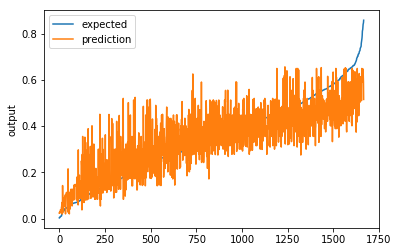

In [9]:
# Plot the Lift Chart:

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

pred=grid_search.predict(X_test)
chart_regression(pred.flatten(), np.array(y_test), sort=True)

In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_inv=scaler_y.inverse_transform(pd.DataFrame(pred))
y_test_inv=scaler_y.inverse_transform(y_test)

# rmse = sqrt(mean_squared_error(np.e**y_test_inv, np.e**pred_inv))
rmse = sqrt(mean_squared_error(y_test_inv**2, pred_inv**2))
print('Test rmse: ', rmse)

Test rmse:  1107.1646128949335


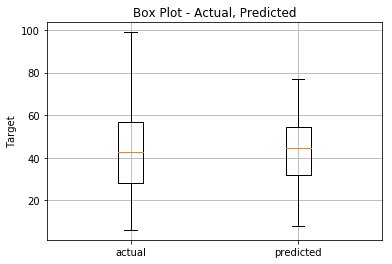

In [15]:
plt.boxplot([y_test_inv.ravel(), pred_inv.ravel()], labels=['actual','predicted'])
plt.title('Box Plot - Actual, Predicted')
plt.ylabel('Target')
plt.grid(True)

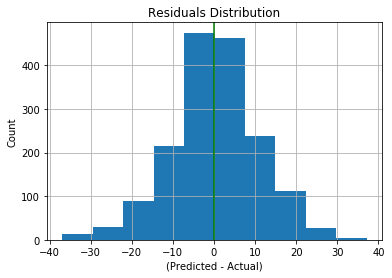

In [16]:
# Over prediction and Under Prediction needs to be balanced:
# Training Data Residuals
residuals = y_test_inv.ravel()-pred_inv.ravel()

plt.hist(residuals)
plt.grid(True)
plt.xlabel('(Predicted - Actual)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='g')
plt.show()

('Item_MRP', 0.46753246)
('Item_Visibility', 0.18326119)
('Outlet_Type', 0.10822511)
('Outlet_Establishment_Year', 0.096681096)
('Outlet_Size', 0.01875902)
('Item_Type-6', 0.017316017)
('Item_Type-12', 0.015873017)
('Item_Type-1', 0.0115440115)
('Item_Type-4', 0.0115440115)
('Item_Type-10', 0.0115440115)
('Outlet_Location_Type', 0.01010101)
('Item_Type-0', 0.01010101)
('Item_Fat_Content', 0.008658009)
('Item_Type-9', 0.008658009)
('Item_Type-3', 0.007215007)
('Item_Type-8', 0.0028860029)
('Item_Type-13', 0.0028860029)
('Item_Type-2', 0.0014430014)
('Item_Type-5', 0.0014430014)
('Item_Type-7', 0.0014430014)
('Item_Type-14', 0.0014430014)
('Item_Type-15', 0.0014430014)
('Item_Type-11', 0.0)


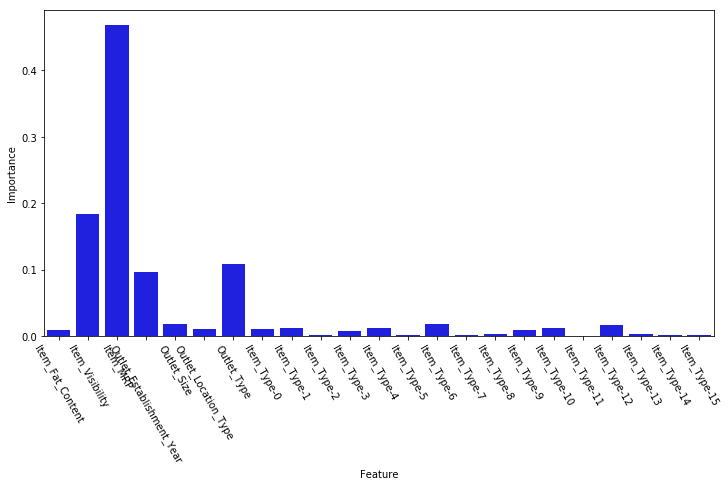

In [17]:
im=XGBRegressor().fit(X, y).feature_importances_

# Sort & Plot:
d=dict(zip(np.array(X.columns), im))
k=sorted(d,key=lambda i: d[i], reverse= True)
[print((i,d[i])) for i in k]

# Plot:
c1=pd.DataFrame(np.array(im),  columns=["Importance"])
c2=pd.DataFrame(np.array(X.columns),columns=["Feature"])

fig, ax = plt.subplots(figsize=(12,6)) 
sns.barplot(x="Feature", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)
plt.xticks(rotation=-60)
plt.show()